### 一、检视原数据集

读入数据并检测

In [1]:
import numpy as np
import pandas as pd
from sklearn.metrics import mean_squared_error,mean_absolute_error,r2_score
file=open("data/housing/housing.csv")
train_df=pd.read_csv(file)
train_df.head()
%config Completer.use_jedi = False

每一行都表示一个街区。共有 10 个属性：经度、维度、房屋年龄中位数、总房间数、卧室数量、人口数、家庭数、收入中位数、房屋价值中位数、离大海距离。

In [2]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20640 entries, 0 to 20639
Data columns (total 10 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   longitude           20640 non-null  float64
 1   latitude            20640 non-null  float64
 2   housing_median_age  20640 non-null  float64
 3   total_rooms         20640 non-null  float64
 4   total_bedrooms      20433 non-null  float64
 5   population          20640 non-null  float64
 6   households          20640 non-null  float64
 7   median_income       20640 non-null  float64
 8   median_house_value  20640 non-null  float64
 9   ocean_proximity     20640 non-null  object 
dtypes: float64(9), object(1)
memory usage: 1.6+ MB


可以看出total_bedrooms这一项有缺失值，后面要进行处理。ocean_proximity这一项的数据类型为类别型数据

In [3]:
train_df.ocean_proximity.value_counts()

<1H OCEAN     9136
INLAND        6551
NEAR OCEAN    2658
NEAR BAY      2290
ISLAND           5
Name: ocean_proximity, dtype: int64

value_counts()方法查看都有什么类型，每个类都有多少街区

In [4]:
train_df.describe()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value
count,20640.000000,20640.000000,20640.000000,20640.000000,20433.000000,20640.000000,20640.000000,20640.000000,20640.000000
mean,-119.569704,35.631861,28.639486,2635.763081,537.870553,1425.476744,499.539680,3.870671,206855.816909
std,2.003532,2.135952,12.585558,2181.615252,421.385070,1132.462122,382.329753,1.899822,115395.615874
min,-124.350000,32.540000,1.000000,2.000000,1.000000,3.000000,1.000000,0.499900,14999.000000
25%,-121.800000,33.930000,18.000000,1447.750000,296.000000,787.000000,280.000000,2.563400,119600.000000
50%,-118.490000,34.260000,29.000000,2127.000000,435.000000,1166.000000,409.000000,3.534800,179700.000000
75%,-118.010000,37.710000,37.000000,3148.000000,647.000000,1725.000000,605.000000,4.743250,264725.000000
max,-114.310000,41.950000,52.000000,39320.000000,6445.000000,35682.000000,6082.000000,15.000100,500001.000000


画出每个数值属性的柱状图

array([[<AxesSubplot:title={'center':'longitude'}>,
        <AxesSubplot:title={'center':'latitude'}>,
        <AxesSubplot:title={'center':'housing_median_age'}>],
       [<AxesSubplot:title={'center':'total_rooms'}>,
        <AxesSubplot:title={'center':'total_bedrooms'}>,
        <AxesSubplot:title={'center':'population'}>],
       [<AxesSubplot:title={'center':'households'}>,
        <AxesSubplot:title={'center':'median_income'}>,
        <AxesSubplot:title={'center':'median_house_value'}>]],
      dtype=object)

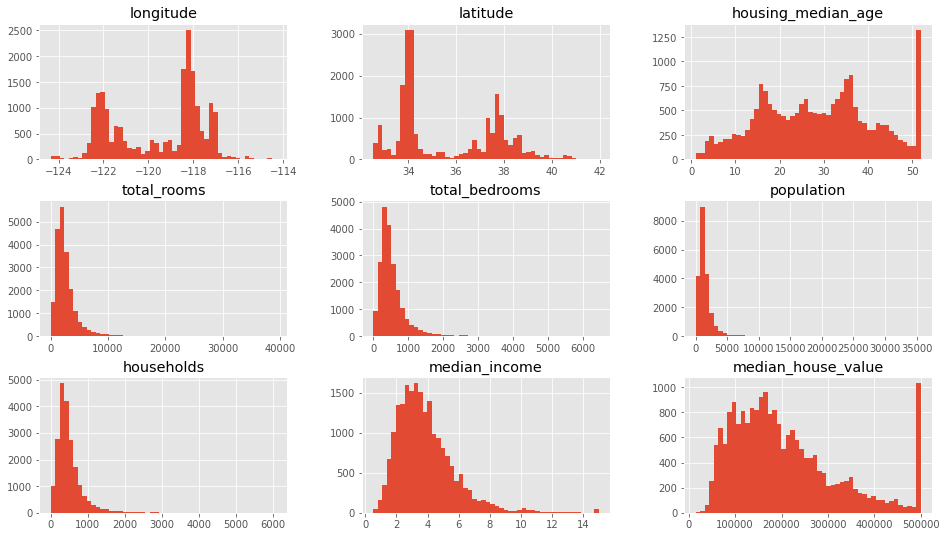

In [5]:
%matplotlib inline
from matplotlib import pyplot as plt
plt.style.use('ggplot')
train_df.hist(bins=50,figsize=(16,9))

从柱状图中可以发现以下问题：  
1.这些属性的量度不一样，在后面需要进行特征缩放  
2.许多柱状图的尾巴过长，对某些机器学习的算法检测规律会变得更难，所以在后面要处理成正态分布。  
3.房屋年龄中位数和房屋价值中位数也被设了上限。后者可能是个严重的问题，因为它是你的目标属性（你的标签）。你的机器学习算法可能学习到价格不会超出这个界限。你需要与下游团队核实，这是否会成为问题。如果他们告诉你他们需要明确的预测值，即使超过 500000，你则有两个选项：1）对于设了上限的标签，重新收集合适的标签；2）将这些街区从训练集移除（也从测试集移除，因为若房价超出 500000，你的系统就会被差评）。  
4.收入数据经过了缩放处理。

### 二、创建测试集
目的：防止数据透视偏差。如果一开始就看过测试集，就会不经意间按照其中的规律选择合适的算法，当再用测试集进行评估时，就会导致结果比较乐观，而实际部署时就比较差了。

In [6]:
from sklearn.model_selection import train_test_split # 留出法
train_set,test_set=train_test_split(train_df,test_size=0.2,random_state=42)

train_test_split函数用于将矩阵随机划分为训练子集和测试子集，并返回划分好的训练集测试集样本和训练集测试集标签。   test_size：如果是浮点数，在0-1之间，表示样本占比；如果是整数的话就是样本的数量。random_state：是随机数的种子。产生总是相同的洗牌指数；如果没有这个每次运行会产生不同的测试集，多次之后会得到整个数据集。

In [7]:
train_set.head(5)

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
14196,-117.03,32.71,33.0,3126.0,627.0,2300.0,623.0,3.2596,103000.0,NEAR OCEAN
8267,-118.16,33.77,49.0,3382.0,787.0,1314.0,756.0,3.8125,382100.0,NEAR OCEAN
17445,-120.48,34.66,4.0,1897.0,331.0,915.0,336.0,4.1563,172600.0,NEAR OCEAN
14265,-117.11,32.69,36.0,1421.0,367.0,1418.0,355.0,1.9425,93400.0,NEAR OCEAN
2271,-119.80,36.78,43.0,2382.0,431.0,874.0,380.0,3.5542,96500.0,INLAND


不足之处：目前都是采用的纯随机抽样，如果数据量比较小，可能会产生偏差。所以需要关注比较重要的属性，对其进行分层抽样，比如说收入中位数。从直方图中可以看出，大多数的值在2-5（万美元），进行分层抽样时保证每一层都要有足够多的数据，这就意味着，层数不能过多。后面的代码将收入中位数除以1.5（以限制分类的数量），创建收入类别属性，用ceil对值舍入（产生离散的分类），并将大于5的分类归入到分类5。inplace=True原数组内容被改变。

In [8]:
train_df["income_cat"]=np.ceil(train_df.median_income/1.5)
train_df["income_cat"].where(train_df["income_cat"]<5,5.0,inplace=True)
train_df["income_cat"].head(5)
train_df["income_cat"].value_counts()/len(train_df)

3.0    0.350581
2.0    0.318847
4.0    0.176308
5.0    0.114438
1.0    0.039826
Name: income_cat, dtype: float64

In [9]:
from sklearn.model_selection import StratifiedShuffleSplit # 模型进行分割，进行洗牌操作
split=StratifiedShuffleSplit(n_splits=1,test_size=0.2,random_state=42) # 数据进行洗牌
for train_index,test_index in split.split(train_df,train_df["income_cat"]):
    start_train_set=train_df.loc[train_index]
    start_test_set=train_df.loc[test_index]
start_train_set.head(5)

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity,income_cat
12655,-121.46,38.52,29.0,3873.0,797.0,2237.0,706.0,2.1736,72100.0,INLAND,2.0
15502,-117.23,33.09,7.0,5320.0,855.0,2015.0,768.0,6.3373,279600.0,NEAR OCEAN,5.0
2908,-119.04,35.37,44.0,1618.0,310.0,667.0,300.0,2.8750,82700.0,INLAND,2.0
14053,-117.13,32.75,24.0,1877.0,519.0,898.0,483.0,2.2264,112500.0,NEAR OCEAN,2.0
20496,-118.70,34.28,27.0,3536.0,646.0,1837.0,580.0,4.4964,238300.0,<1H OCEAN,3.0


In [10]:
for set in(start_train_set,start_test_set):
    set.drop(["income_cat"],axis=1,inplace=True)
start_test_set.head(5)

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
5241,-118.39,34.12,29.0,6447.0,1012.0,2184.0,960.0,8.2816,500001.0,<1H OCEAN
17352,-120.42,34.89,24.0,2020.0,307.0,855.0,283.0,5.0099,162500.0,<1H OCEAN
3505,-118.45,34.25,36.0,1453.0,270.0,808.0,275.0,4.3839,204600.0,<1H OCEAN
7777,-118.10,33.91,35.0,1653.0,325.0,1072.0,301.0,3.2708,159700.0,<1H OCEAN
14155,-117.07,32.77,38.0,3779.0,614.0,1495.0,614.0,4.3529,184000.0,NEAR OCEAN


需要删除income_cat属性，使数据回到初始状态。

### 三、数据探索及可视化
目的：以上只是粗略的查看了统计信息，还需要从样本中发现更多的信息。如果训练集非常大，可能还需要采样一个探索集。如果比较小，可以建立一个副本。

In [11]:
housing=start_train_set.copy()

#### 3.1地理数据可视化
原因：样本中有经度和纬度，所以考虑创建散点图

<AxesSubplot:xlabel='longitude', ylabel='latitude'>

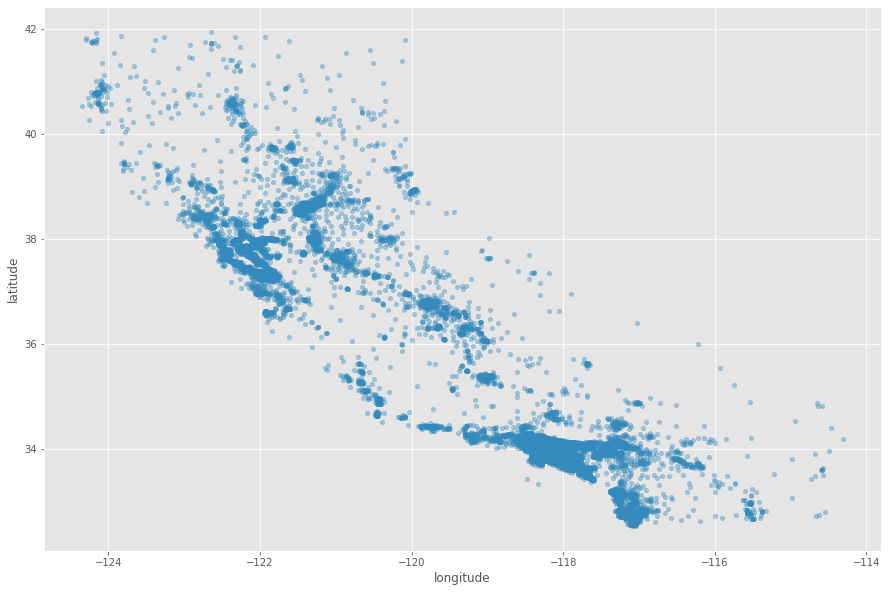

In [12]:
housing.plot(kind="scatter",x="longitude",y="latitude",alpha=0.4,figsize=(15, 10)) # x设置为精度，y设置成纬度， alpha 样本点的透明度
# 样本点颜色重，证明街区多，颜色浅，街区少

高密度区域：湾区、洛杉矶和圣迭戈等

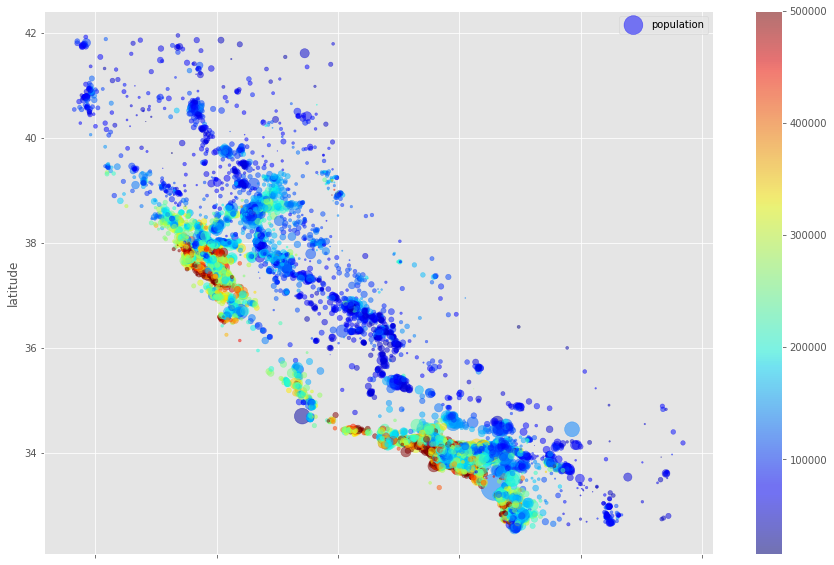

In [13]:
# s 指 样本点的大小，人口多，散点就达，人口少，样本点小
# c 颜色 越红，证明房价越高
housing.plot(kind="scatter",x="longitude",y="latitude",alpha=0.5,
            s=housing.population/50,label="population",
            c=housing.median_house_value,cmap=plt.get_cmap('jet'),colorbar=True,
            figsize=(15, 10))
plt.legend()

加入人口信息，用点的大小来展示（s）。加入房价信息，用颜色的深浅来表示（c），用预先定义的颜色图“jet”，范围从蓝色到红色，即低价到高价。从图中可以发现房价和位置（沿海地区）以及人口密度存在联系。

C:\Users\q1425\AppData\Local\Temp\ipykernel_17136\3475853668.py:12: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
  fig.colorbar(bubble)


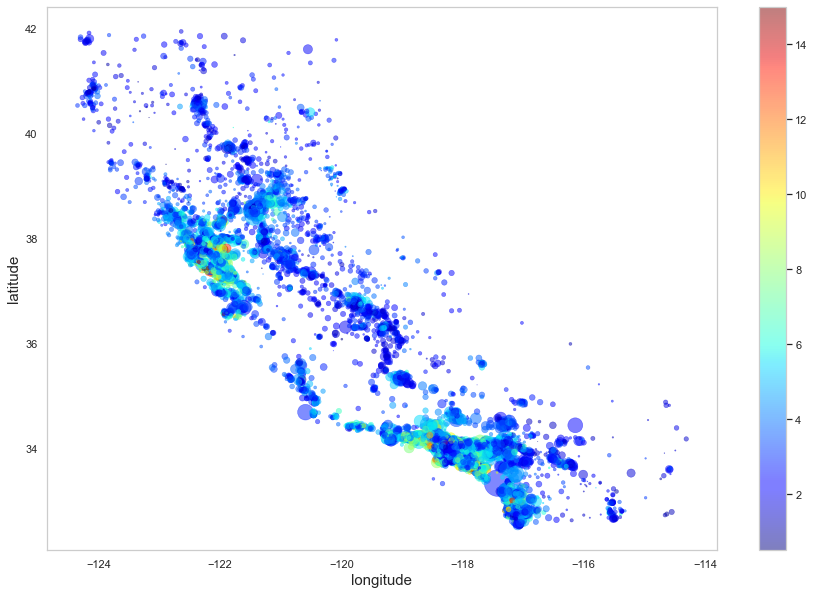

In [14]:
import seaborn as sns # matplotlib一个封装
sns.set(style = "whitegrid")#设置样式
x = housing.longitude#X轴数据
y = housing.latitude#Y轴数据
z = housing.median_income#用来调整各个点的大小s
cm = plt.get_cmap('jet')
fig,ax = plt.subplots(figsize = (15,10))
#注意s离散化的方法，因为需要通过点的大小来直观感受其所表示的数值大小
#参数是X轴数据、Y轴数据、各个点的大小、各个点的颜色
bubble = ax.scatter(x, y , s = housing.population/50, c = z, cmap = cm, linewidth = 0.5, alpha = 0.5)
ax.grid()
fig.colorbar(bubble)
ax.set_xlabel('longitude', fontsize = 15)#X轴标签
ax.set_ylabel('latitude', fontsize = 15)#Y轴标签
plt.show()

利用seaborn作图也可以达到同样效果。加入人口信息，用点的大小来展示（s）。加入收入信息，用颜色的深浅来表示（c），用预先定义的颜色图“jet”，范围从蓝色到红色，即低价到高价。从图中可以发现收入和位置（沿海地区）以及人口密度存在一定的联系，但是效果不是十分明显。

#### 3.2查看特征之间相关性

In [15]:
corr_matrix=housing.corr()# 统计列与列之间的相关系数
corr_matrix["median_house_value"].sort_values(ascending=False)

median_house_value    1.000000
median_income         0.687151
total_rooms           0.135140
housing_median_age    0.114146
households            0.064590
total_bedrooms        0.047781
population           -0.026882
longitude            -0.047466
latitude             -0.142673
Name: median_house_value, dtype: float64

用热力图的方式展现相关性。annot(annotate的缩写):默认取值False；如果是True，在热力图每个方格写入数据；vmax,vmin:分别是热力图的颜色取值最大和最小范围，默认是根据data数据表里的取值确定。

<AxesSubplot:>

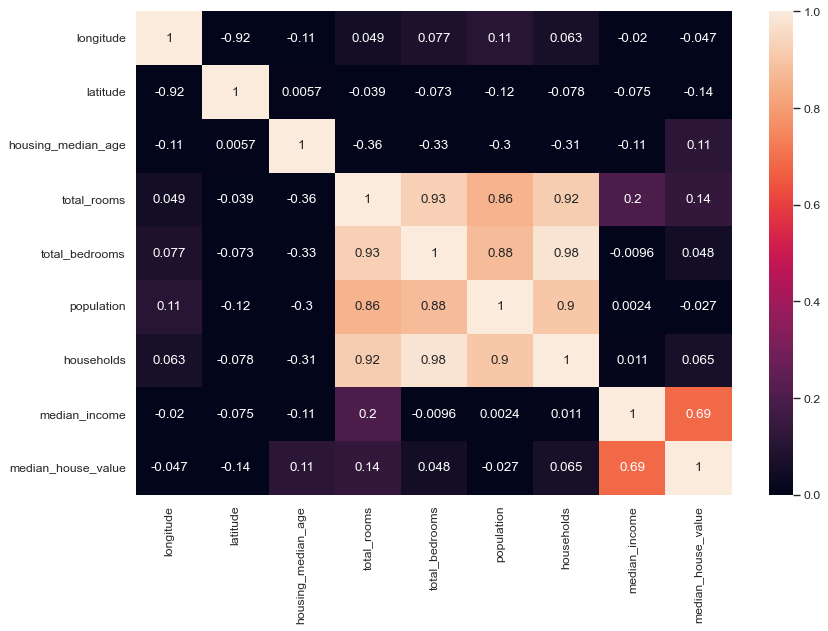

In [16]:
import seaborn as sns
fig=plt.figure(figsize=(12,8),dpi=80)
sns.heatmap(housing.corr(),annot =True,vmin = 0, vmax = 1)

用可视化的方式展现相关性，因为属性过多，所以选取部分属性。

array([[<AxesSubplot:xlabel='median_house_value', ylabel='median_house_value'>,
        <AxesSubplot:xlabel='median_income', ylabel='median_house_value'>,
        <AxesSubplot:xlabel='total_rooms', ylabel='median_house_value'>,
        <AxesSubplot:xlabel='housing_median_age', ylabel='median_house_value'>],
       [<AxesSubplot:xlabel='median_house_value', ylabel='median_income'>,
        <AxesSubplot:xlabel='median_income', ylabel='median_income'>,
        <AxesSubplot:xlabel='total_rooms', ylabel='median_income'>,
        <AxesSubplot:xlabel='housing_median_age', ylabel='median_income'>],
       [<AxesSubplot:xlabel='median_house_value', ylabel='total_rooms'>,
        <AxesSubplot:xlabel='median_income', ylabel='total_rooms'>,
        <AxesSubplot:xlabel='total_rooms', ylabel='total_rooms'>,
        <AxesSubplot:xlabel='housing_median_age', ylabel='total_rooms'>],
       [<AxesSubplot:xlabel='median_house_value', ylabel='housing_median_age'>,
        <AxesSubplot:xlabel='median_incom

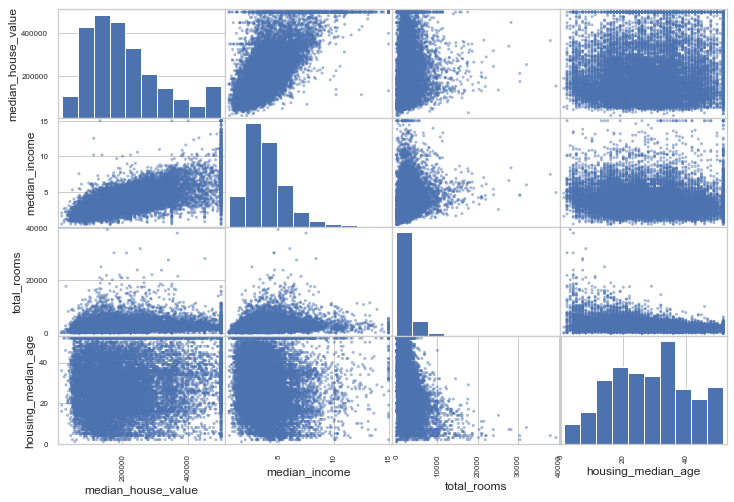

In [17]:
from pandas.plotting import scatter_matrix # 使用散点图矩阵图，可以两两发现特征之间的联系
attributes=["median_house_value","median_income","total_rooms","housing_median_age" ]
scatter_matrix(housing[attributes],figsize=(12,8))

对角线表示每个属性的柱状图。图中可以看出收入对房价的影响还是比较大的，所以可以放大进行研究。

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.


<AxesSubplot:xlabel='median_income', ylabel='median_house_value'>

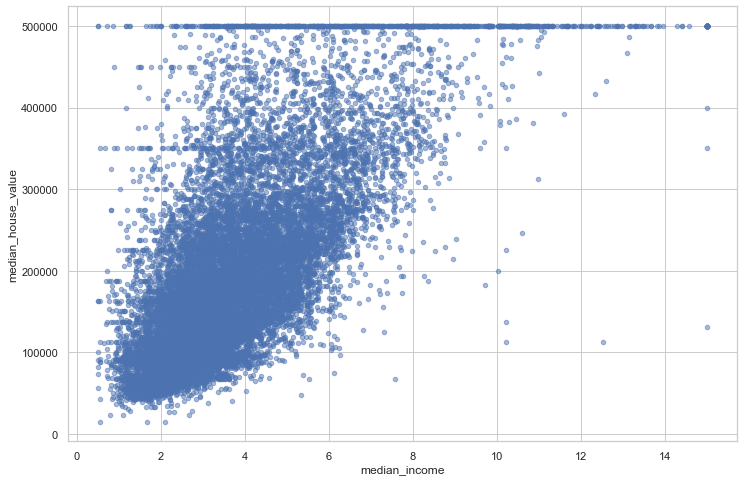

In [18]:
housing.plot(kind="scatter",x="median_income",y="median_house_value",alpha=0.5,figsize=(12,8))

可以看出相关性还是很高的。其次，可以看到一些直线：500000,450000,350000,280000美元，可能是收集资料时设立的边界。

#### 3.3属性组合试验

有一些属性，比如总房间数，在不知道街区有多少户的情况下用处不大。同理总卧室数和总人口数。

In [19]:
housing["rooms_per_household"]=housing.total_rooms/housing.households
housing["bedrooms_per_room"]=housing.total_bedrooms/housing.total_rooms
housing["population_per_household"]=housing.population/housing.households
corr_matrix =housing.corr()
corr_matrix["median_house_value"].sort_values(ascending=False)

median_house_value          1.000000
median_income               0.687151
rooms_per_household         0.146255
total_rooms                 0.135140
housing_median_age          0.114146
households                  0.064590
total_bedrooms              0.047781
population_per_household   -0.021991
population                 -0.026882
longitude                  -0.047466
latitude                   -0.142673
bedrooms_per_room          -0.259952
Name: median_house_value, dtype: float64

间数和卧室数更有信息。而且每户的房间数越多，意味着房屋更大，房价越高，比单纯的看总房间数更有信息

### 四、数据预处理
目的：为机器学习算法准备数据。  
将训练集中预测量和标签分开，因为之后对其要进行不同的转换；drop（）创建备份，不影响原数据集。

In [20]:
# 数据拷贝
housing=start_train_set.drop("median_house_value",axis=1)
housing_copy=housing.copy()
housing_labels=start_train_set.median_house_value.copy()
print(housing.head(5))
print(housing_labels.head(5))

       longitude  latitude  housing_median_age  total_rooms  total_bedrooms  \
12655    -121.46     38.52                29.0       3873.0           797.0   
15502    -117.23     33.09                 7.0       5320.0           855.0   
2908     -119.04     35.37                44.0       1618.0           310.0   
14053    -117.13     32.75                24.0       1877.0           519.0   
20496    -118.70     34.28                27.0       3536.0           646.0   

       population  households  median_income ocean_proximity  
12655      2237.0       706.0         2.1736          INLAND  
15502      2015.0       768.0         6.3373      NEAR OCEAN  
2908        667.0       300.0         2.8750          INLAND  
14053       898.0       483.0         2.2264      NEAR OCEAN  
20496      1837.0       580.0         4.4964       <1H OCEAN  
12655     72100.0
15502    279600.0
2908      82700.0
14053    112500.0
20496    238300.0
Name: median_house_value, dtype: float64


#### 4.1数据清洗  
目的：处理缺省值。因为很多机器学习算法对缺省值比较敏感（例如LR和SVM，决策树和朴素贝叶斯相对好一点）
思路：  
1）去掉缺失的行数据dropna（）；  
2）去掉缺失的列drop（）；3）进行赋值fillna（）,可以是0、平均数和中位数。

In [21]:
# 中值填充
median=housing.total_bedrooms.median()
housing.total_bedrooms=housing.total_bedrooms.fillna(median)
housing.isnull().sum().sum()

0

#### 4.2处理文本和类别属性
pandas自带的get_dummies方法，可以帮你一键做到One-Hot。  
可以看出类别属性ocean_proximity被我们分成了5个column，每一个代表一个category。是就是1，不是就是0。

In [22]:
housing=pd.get_dummies(housing)# onehot
housing.head(5)

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,ocean_proximity_<1H OCEAN,ocean_proximity_INLAND,ocean_proximity_ISLAND,ocean_proximity_NEAR BAY,ocean_proximity_NEAR OCEAN
12655,-121.46,38.52,29.0,3873.0,797.0,2237.0,706.0,2.1736,0,1,0,0,0
15502,-117.23,33.09,7.0,5320.0,855.0,2015.0,768.0,6.3373,0,0,0,0,1
2908,-119.04,35.37,44.0,1618.0,310.0,667.0,300.0,2.8750,0,1,0,0,0
14053,-117.13,32.75,24.0,1877.0,519.0,898.0,483.0,2.2264,0,0,0,0,1
20496,-118.70,34.28,27.0,3536.0,646.0,1837.0,580.0,4.4964,1,0,0,0,0


#### 4.3特征缩放
当输入的属性量度不同时，会影响机器学习算法的性能。比如总房间数分布范围在6-39320，收入中位数在0-15。两种方法：归一化和标准化。归一化将数值缩放到0-1之间，标准化不会限定到某个范围，对一些算法有影响，像神经网络算法输入值就必须是0-1。但是异常值对标准化的影响较小。

In [23]:
numeric_cols=housing_copy.columns[housing_copy.dtypes!="object"]
print(numeric_cols)

Index(['longitude', 'latitude', 'housing_median_age', 'total_rooms',
       'total_bedrooms', 'population', 'households', 'median_income'],
      dtype='object')


In [24]:
numeric_col_means = housing.loc[:, numeric_cols].mean()
numeric_col_std = housing.loc[:, numeric_cols].std()
housing.loc[:, numeric_cols] = (housing.loc[:, numeric_cols] - numeric_col_means) /numeric_col_std
housing.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,ocean_proximity_<1H OCEAN,ocean_proximity_INLAND,ocean_proximity_ISLAND,ocean_proximity_NEAR BAY,ocean_proximity_NEAR OCEAN
12655,-0.941322,1.347397,0.027563,0.584760,0.640352,0.732580,0.556269,-0.893620,0,1,0,0,0
15502,1.171747,-1.192404,-1.721965,1.261428,0.781538,0.533595,0.721296,1.292129,0,0,0,0,1
2908,0.267573,-0.125968,1.220423,-0.469759,-0.545122,-0.674655,-0.524391,-0.525418,0,1,0,0,0
14053,1.221701,-1.351433,-0.370057,-0.348641,-0.036366,-0.467603,-0.037296,-0.865903,0,0,0,0,1
20496,0.437418,-0.635799,-0.131485,0.427167,0.272782,0.374049,0.220892,0.325742,1,0,0,0,0


In [25]:
housing_labels=(housing_labels-housing_labels.mean())/housing_labels.std() # 标准化处理
housing_labels.head()

12655   -1.165979
15502    0.627432
2908    -1.074364
14053   -0.816804
20496    0.270478
Name: median_house_value, dtype: float64

### 五、模型选择和训练

#### 5.1 在训练集上训练和评估

In [26]:
from sklearn.linear_model import LinearRegression
lin_reg=LinearRegression()

将pandas类型转换为ndarray

In [27]:
X_train=housing.values
X_test=housing_labels.values
print(X_train)
print(X_test)

[[-0.94132195  1.34739741  0.02756274 ...  0.          0.
   0.        ]
 [ 1.17174663 -1.19240355 -1.72196548 ...  0.          0.
   1.        ]
 [ 0.26757308 -0.12596778  1.22042289 ...  0.          0.
   0.        ]
 ...
 [-1.57074664  1.30997862  1.53851892 ...  0.          0.
   0.        ]
 [-1.56075577  1.24917307 -1.16529741 ...  0.          0.
   0.        ]
 [-1.28101147  2.02561314 -0.13148528 ...  0.          0.
   0.        ]]
[-1.16597934  0.62743184 -1.07436412 ... -0.57566617  0.44160851
 -1.24722303]


先训练一个线性回归模型

In [28]:
lin_reg.fit(X_train,X_test)

LinearRegression()

训练完成，用交叉验证法进行模型评估。交叉验证的基本思想是将训练数据集分为k份，每次用k-1份训练模型，用剩余的1份作为验证集。按顺序训练k次后，计算k次的平均误差来评价模型（改变参数后即为另一个模型）的好坏。

In [29]:
from sklearn.model_selection import cross_val_score 
lin_reg_scores=cross_val_score(lin_reg,X_train,X_test,scoring="neg_mean_squared_error",cv=10)
lin_reg_rmse_scores=np.sqrt(-lin_reg_scores)
print(lin_reg_rmse_scores.mean()) # rmse


0.5981291860994167


均方根误差（RMSE），回归任务可靠的性能指标。  
利用决策树模型试试看

In [33]:
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import r2_score
tree_reg=DecisionTreeRegressor()
tree_reg.fit(X_train,X_test)
tree_reg_scores=cross_val_score(tree_reg,X_train,X_test,scoring="neg_mean_squared_error",cv=10)
tree_reg_rmse_scores=np.sqrt(-tree_reg_scores)
print(tree_reg_rmse_scores.mean())

0.5954143203614133


可以看出决策树模型的误差大于线性回归，性能更差一点。现在选择用随机森林尝试一下。

In [32]:
from sklearn.ensemble import RandomForestRegressor
RF_reg=RandomForestRegressor()
RF_reg.fit(X_train,X_test)
RF_reg_scores=cross_val_score(RF_reg,X_train,X_test,scoring="neg_mean_squared_error",cv=10)
RF_reg_rmse_scores=np.sqrt(-RF_reg_scores)
print(RF_reg_rmse_scores.mean())

0.4267379197376475


随机森林速度慢一点，误差更小，明显更有希望。

#### 5.2 利用网格搜索对模型进行微调
只要提供超参数和试验的值，网格搜索就可以使用交叉验证试验所有可能超参数值的组合。

In [34]:
from sklearn.model_selection import GridSearchCV
param_grid = [
{'n_estimators': [3, 10, 30], 'max_features': [2, 4, 6, 8]},
{'bootstrap': [False], 'n_estimators': [3, 10], 'max_features': [2, 3, 4]},
]
forest_reg = RandomForestRegressor()
grid_search = GridSearchCV(forest_reg, param_grid, cv=5,
scoring='neg_mean_squared_error')
grid_search.fit(X_train,X_test)

GridSearchCV(cv=5, estimator=RandomForestRegressor(),
             param_grid=[{'max_features': [2, 4, 6, 8],
                          'n_estimators': [3, 10, 30]},
                         {'bootstrap': [False], 'max_features': [2, 3, 4],
                          'n_estimators': [3, 10]}],
             scoring='neg_mean_squared_error')

首先调第一行的参数为n_estimators和max_features，即有34=12种组合，然后再调第二行的参数，即23=6种组合，具体参数的代表的意思以后再讲述。总共组合数为12+6=18种组合。每种交叉验证5次，即18*5=90次模型计算，虽然运算量比较大，但运行完后能得到较好的参数

In [35]:
grid_search.best_params_

{'max_features': 8, 'n_estimators': 30}

可以看到最好参数中30是选定参数的边缘，所以可以再选更大的数试验，可能会得到更好的模型，还可以在8附近选定参数，也可能会得到更好的模型。

In [36]:
grid_search.best_estimator_

RandomForestRegressor(max_features=8, n_estimators=30)

#### 5.3 用测试集去评估系统

In [37]:
from sklearn.metrics import mean_squared_error
final_model = grid_search.best_estimator_
X_test = start_test_set.drop("median_house_value", axis=1)
y_test = start_test_set["median_house_value"].copy()
median=X_test.total_bedrooms.median()
X_test.total_bedrooms=X_test.total_bedrooms.fillna(median)
X_test=pd.get_dummies(X_test)
numeric_col_means = X_test.loc[:, numeric_cols].mean()
numeric_col_std = X_test.loc[:, numeric_cols].std()
X_test.loc[:, numeric_cols] = (X_test.loc[:, numeric_cols] - numeric_col_means) /numeric_col_std
y_test=(y_test-y_test.mean())/y_test.std()
final_predictions = final_model.predict(X_test)
final_mse = mean_squared_error(y_test, final_predictions)
final_rmse = np.sqrt(final_mse) 
print(final_rmse)
print(r2_score(y_test, final_predictions))

0.45923502856066134
0.7890520868197344


D:\python\lib\site-packages\sklearn\base.py:443: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  warnings.warn(


把测试集进行预处理，导入到系统中，误差为0.4584388288700149，模型的表现还不错，没有出现过拟合。

建议： 并没有打印分数  R2的值